In [1]:
# Importing libraries

import pandas as pd
import numpy as np

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Data exploration

In [2]:
df = pd.read_csv('Credit_card.csv')
df_values = pd.read_csv('Credit_card_label.csv')

In [3]:
# Exploring first 5 rows of the data

df.head() 

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2


In [4]:
df_values.head()

,Ind_ID,label
0,5008827,1
1,5009744,1
2,5009746,1
3,5009749,1
4,5009752,1


In [5]:
data_1 = df_values.label.value_counts()
data_1

label
0    1373
1     175
Name: count, dtype: int64

Let's visualize the ratio of approvals vs declines

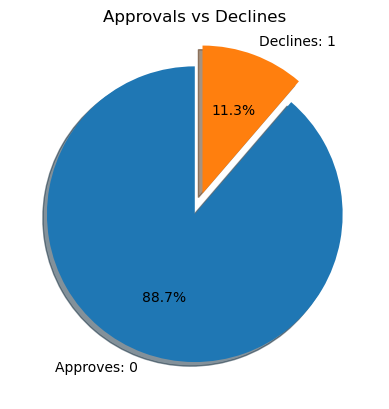

In [91]:
fig, ax = plt.subplots()
explode = (0, 0.15)

names = ['Approves', 'Declines']

ax.pie(data_1, 
       labels=[f'{names[i]}: {data_2.index[i]}' for i in range(len(data_2))],
       explode = explode, 
       #autopct='%1.1f%%', 
       shadow=True, 
       startangle=90, 
       autopct='%1.1f%%',
       # labels = [ 'Approves', 'Declines']
      )

plt.title('Approvals vs Declines')
plt.show()

In this dataset the target valuables represent application approval with 0 and application rejection with 1. In order for the data to be more intuitive we will reverse these so approval will be represented as 1 and rejection as 0. 

Our data base is very imbalanced, we have a lot more approval rate than declines, with approximate ratio 1 to 8. 

In [10]:
# Combining our features with values

df = pd.merge(df, df_values, on = 'Ind_ID')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ind_ID           1548 non-null   int64  
 1   GENDER           1541 non-null   object 
 2   Car_Owner        1548 non-null   object 
 3   Propert_Owner    1548 non-null   object 
 4   CHILDREN         1548 non-null   int64  
 5   Annual_income    1525 non-null   float64
 6   Type_Income      1548 non-null   object 
 7   EDUCATION        1548 non-null   object 
 8   Marital_status   1548 non-null   object 
 9   Housing_type     1548 non-null   object 
 10  Birthday_count   1526 non-null   float64
 11  Employed_days    1548 non-null   int64  
 12  Mobile_phone     1548 non-null   int64  
 13  Work_Phone       1548 non-null   int64  
 14  Phone            1548 non-null   int64  
 15  EMAIL_ID         1548 non-null   int64  
 16  Type_Occupation  1060 non-null   object 
 17  Family_Members

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ind_ID,1548.0,5.078920e+06,41717.587742,5008827.0,5045069.75,5078841.5,5115673.00,5150412.0
CHILDREN,1548.0,4.127907e-01,0.776691,0.0,0.00,0.0,1.00,14.0
Annual_income,1525.0,1.913993e+05,113252.997656,33750.0,121500.00,166500.0,225000.00,1575000.0
Birthday_count,1526.0,-1.604034e+04,4229.503202,-24946.0,-19553.00,-15661.5,-12417.00,-7705.0
Employed_days,1548.0,5.936469e+04,137808.062701,-14887.0,-3174.50,-1565.0,-431.75,365243.0
Mobile_phone,1548.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
Work_Phone,1548.0,2.080103e-01,0.406015,0.0,0.00,0.0,0.00,1.0
Phone,1548.0,3.094315e-01,0.462409,0.0,0.00,0.0,1.00,1.0
EMAIL_ID,1548.0,9.237726e-02,0.289651,0.0,0.00,0.0,0.00,1.0
Family_Members,1548.0,2.161499e+00,0.947772,1.0,2.00,2.0,3.00,15.0


In [13]:
# Checking unique values in all columns

for col in df.columns:
    print(col)
    
    print(df[col].unique())
    print()

Ind_ID
[5008827 5009744 5009746 ... 5115992 5118219 5053790]

GENDER
['M' 'F' nan]

Car_Owner
['Y' 'N']

Propert_Owner
['Y' 'N']

CHILDREN
[ 0  1  2  4  3 14]

Annual_income
[ 180000.   315000.        nan  450000.    90000.   472500.   270000.
  126000.   202500.   157500.   112500.   540000.   292500.   135000.
   76500.   215100.   225000.    67500.   171000.   103500.    99000.
  391500.    65250.    72900.   360000.   256500.   675000.   247500.
   85500.   121500.   130500.   211500.    81000.    72000.   148500.
  162000.   195750.   585000.   216000.   306000.   108000.    63000.
   45000.   337500.   131400.   117000.   445500.   234000.  1575000.
  144000.    67050.    73350.   193500.   900000.    94500.   198000.
   54000.   166500.   167400.   153000.   423000.   243000.   283500.
  252000.   495000.   612000.    36000.   139500.   133650.   427500.
  261000.   231750.    90900.    45900.   119250.    58500.   328500.
  787500.   594000.   119700.    69372.    37800.   3870

# Data preparation

Shuffling the ordering of the rows in the database is an essential step in preparing your data for machine learning training. Let's do that. 

In [14]:
np.random.seed(1)
df = df.loc[np.random.permutation(len(df))]

Upon the inspection, we can see that column 'Mobile_phone' contains only one value of 1, thus we can safely remove it as will not affect our data. 

In [15]:
df.drop(columns = ['Mobile_phone', 'Ind_ID'], axis =1, inplace=True)

In [16]:
# Checking for duplicate rows 

dups = df.duplicated()
df[dups]

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
102,F,N,N,0,135000.0,Working,Secondary / secondary special,Widow,Co-op apartment,-20012.0,-584,0,0,0,Core staff,1,1
1116,M,Y,Y,0,225000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-17454.0,365243,0,1,0,NaN,1,0
159,F,N,Y,0,67500.0,Commercial associate,Higher education,Separated,House / apartment,-18952.0,-499,0,1,0,Core staff,1,1
87,F,N,Y,2,180000.0,Working,Incomplete higher,Separated,House / apartment,-12253.0,-3496,1,0,0,NaN,3,1
120,M,Y,Y,0,126000.0,Working,Higher education,Single / not married,House / apartment,-14522.0,-863,1,0,0,Managers,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,M,Y,Y,0,315000.0,Working,Higher education,Married,House / apartment,-18335.0,-2796,0,0,0,Drivers,2,0
1202,F,N,Y,0,126000.0,Working,Secondary / secondary special,Married,House / apartment,-22811.0,-2234,1,1,0,High skill tech staff,2,0
1414,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,-15366.0,-1266,1,1,0,Drivers,2,0
144,M,N,Y,0,112500.0,Commercial associate,Higher education,Married,House / apartment,-20103.0,-555,0,0,0,Security staff,2,1


In [17]:
# There are 162 dublicates which we can remove

df = df.drop_duplicates().reset_index(drop=True)

In [18]:
# Replacing column names with lowercase

df.rename(columns=lambda x: x.lower(), inplace=True) 

In [19]:
# Verifying results

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           1379 non-null   object 
 1   car_owner        1386 non-null   object 
 2   propert_owner    1386 non-null   object 
 3   children         1386 non-null   int64  
 4   annual_income    1363 non-null   float64
 5   type_income      1386 non-null   object 
 6   education        1386 non-null   object 
 7   marital_status   1386 non-null   object 
 8   housing_type     1386 non-null   object 
 9   birthday_count   1364 non-null   float64
 10  employed_days    1386 non-null   int64  
 11  work_phone       1386 non-null   int64  
 12  phone            1386 non-null   int64  
 13  email_id         1386 non-null   int64  
 14  type_occupation  948 non-null    object 
 15  family_members   1386 non-null   int64  
 16  label            1386 non-null   int64  
dtypes: float64(2),

In [20]:
# Converting birthday count days into years

df['birthday_count'] = abs(df['birthday_count']/365).round()

In [21]:
df['birthday_count'].unique()

array([40., 38., 39., 42., 37., 25., 27., 30., 32., 51., 45., 44., 56.,
       52., 55., 47., 29., 34., 53., 35., 48., 63., 41., 31., 23., 54.,
       26., 28., nan, 57., 67., 33., 58., 36., 62., 49., 66., 65., 64.,
       50., 46., 59., 61., 43., 60., 21., 24., 68., 22.])

In [22]:
# Creating a new column for unemployment

df['unemployed'] = df['employed_days'] >=0

# Converting booleans into integers

df['unemployed'] = np.multiply(df['unemployed'], 1) 

In [23]:
df['unemployed'].value_counts() # verifying results

unemployed
0    1149
1     237
Name: count, dtype: int64

In [24]:
# Creating a new column for employment

df['employed'] = df['employed_days'] < 0 

# Converting booleans into integers

df['employed'] = np.multiply(df['employed'], 1)
df['employed'].value_counts() # verifying results

employed
1    1149
0     237
Name: count, dtype: int64

In [25]:
# Removing positive values indicating unemployment from 'employed_days' column

df['employed_days'] = df['employed_days'].apply(lambda x: x if x < 0 else None)

In [26]:
df['employed_days'].value_counts()

employed_days
-460.0     5
-1678.0    5
-140.0     4
-586.0     4
-678.0     4
          ..
-500.0     1
-980.0     1
-3663.0    1
-4161.0    1
-3093.0    1
Name: count, Length: 955, dtype: int64

In [27]:
# Converting 'employment_days' into 'employment_years'

df['employed_years'] = abs(df['employed_days']/365).round(1)

In [28]:
# Removing 'employed_days' column as its data has been converted to 'employed', 'unemployed'
# and 'employed_years' columns

df.drop(['employed_days'], axis =1, inplace=True)

# Handling Missing Values with Imputation

In [29]:
df.isnull().sum()

gender               7
car_owner            0
propert_owner        0
children             0
annual_income       23
type_income          0
education            0
marital_status       0
housing_type         0
birthday_count      22
work_phone           0
phone                0
email_id             0
type_occupation    438
family_members       0
label                0
unemployed           0
employed             0
employed_years     237
dtype: int64

Let's visualize our missing data

<Axes: >

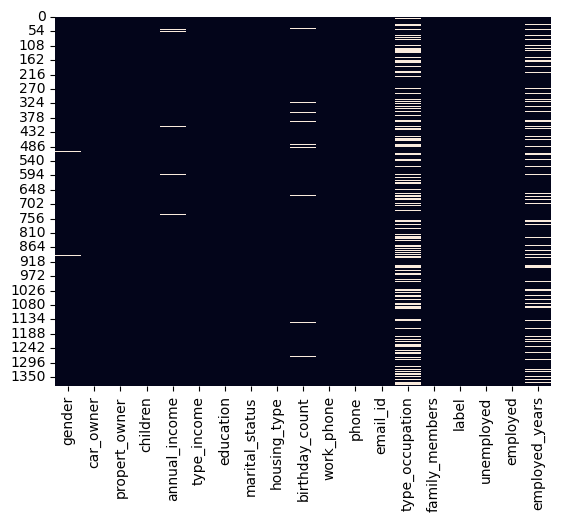

In [30]:
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False)

Missing values in 'employed_years' column suggest that the person is currently unemployed, hence we can substitute NaN values with 0

In [31]:
# Replacing missing values with 0

df['employed_years'] = df['employed_years'].fillna(0)
df['employed_years'].isnull().sum() # Verifyingh results

0

In [32]:
# Replacing missing values in non-numeric column 'type_occupation' with 'unknown'

df['type_occupation'] = df['type_occupation'].fillna('unknown')

In [33]:
df.type_occupation.value_counts()

type_occupation
unknown                  438
Laborers                 240
Core staff               155
Managers                 116
Sales staff              111
Drivers                   77
High skill tech staff     59
Medicine staff            43
Accountants               41
Security staff            21
Cleaning staff            20
Cooking staff             20
Private service staff     17
Low-skill Laborers         9
Secretaries                8
Waiters/barmen staff       5
HR staff                   3
Realty agents              2
IT staff                   1
Name: count, dtype: int64

For numeric columns, it's very common to replace missing values with the mean. 
In our case missing values in 'annual_income' and 'birthday_count' columns represent less than 2% of the total data, thus this approach is justifiable.  

In [34]:
birthday_mean = df['birthday_count'].mean()
df['birthday_count'] = df['birthday_count'].fillna(value = birthday_mean)
df['birthday_count'].isnull().sum() # verifying results

0

In [35]:
income_mean = df['annual_income'].mean()
df['annual_income'] = df['annual_income'].fillna(value = income_mean)
df['annual_income'].isnull().sum() # verifying results

0

Lastly there is less than 1% of total data is missing in gender column, therefor dropping these rows will not significantly impact our data base. 

In [36]:
df = df.dropna().reset_index(drop=True)
df.info() # verifying index reset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           1379 non-null   object 
 1   car_owner        1379 non-null   object 
 2   propert_owner    1379 non-null   object 
 3   children         1379 non-null   int64  
 4   annual_income    1379 non-null   float64
 5   type_income      1379 non-null   object 
 6   education        1379 non-null   object 
 7   marital_status   1379 non-null   object 
 8   housing_type     1379 non-null   object 
 9   birthday_count   1379 non-null   float64
 10  work_phone       1379 non-null   int64  
 11  phone            1379 non-null   int64  
 12  email_id         1379 non-null   int64  
 13  type_occupation  1379 non-null   object 
 14  family_members   1379 non-null   int64  
 15  label            1379 non-null   int64  
 16  unemployed       1379 non-null   int32  
 17  employed      

In [37]:
# Verifying results

df.isnull().sum()

gender             0
car_owner          0
propert_owner      0
children           0
annual_income      0
type_income        0
education          0
marital_status     0
housing_type       0
birthday_count     0
work_phone         0
phone              0
email_id           0
type_occupation    0
family_members     0
label              0
unemployed         0
employed           0
employed_years     0
dtype: int64

# Working with outliers

<Axes: xlabel='annual_income', ylabel='Count'>

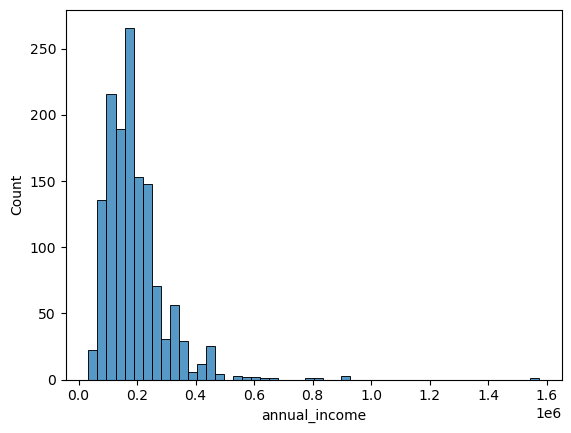

In [38]:
import warnings
warnings.filterwarnings("ignore")
sns.histplot(df.annual_income, bins = 50)

It is common practice to apply logarithmic function to data with long tail distribution. It can help make the distribution more symmetric, potentially stabilizing the variance and making it more suitable for certain types of analysis or modeling.

<Axes: xlabel='log_income', ylabel='Count'>

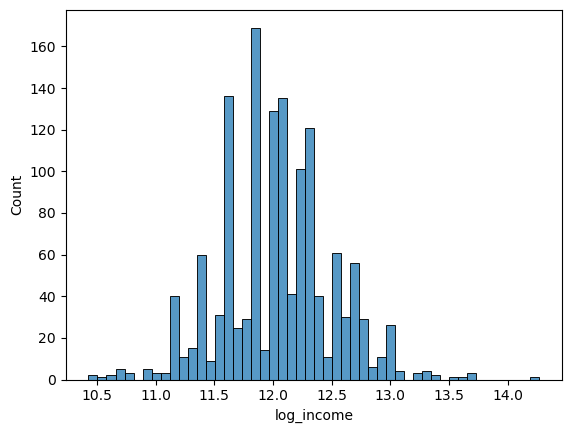

In [39]:
df['log_income'] = np.log1p(df.annual_income)
sns.histplot(df.log_income, bins = 50)

In [40]:
df.drop(['annual_income'], axis = 1, inplace =True)
df.dtypes

gender              object
car_owner           object
propert_owner       object
children             int64
type_income         object
education           object
marital_status      object
housing_type        object
birthday_count     float64
work_phone           int64
phone                int64
email_id             int64
type_occupation     object
family_members       int64
label                int64
unemployed           int32
employed             int32
employed_years     float64
log_income         float64
dtype: object

# Working with categorical data

In [41]:
df.dtypes

gender              object
car_owner           object
propert_owner       object
children             int64
type_income         object
education           object
marital_status      object
housing_type        object
birthday_count     float64
work_phone           int64
phone                int64
email_id             int64
type_occupation     object
family_members       int64
label                int64
unemployed           int32
employed             int32
employed_years     float64
log_income         float64
dtype: object

In [42]:
df['propert_owner'].value_counts()

propert_owner
Y    899
N    480
Name: count, dtype: int64

In [43]:
# Converting categorical 'propert_owner' values into numerical. 1 stands for Yes and 0 for No

df['propert_owner'] = (df['propert_owner'] == 'Y').astype(int)
df['propert_owner'].value_counts() # verifying results

propert_owner
1    899
0    480
Name: count, dtype: int64

In [44]:
df['car_owner'].value_counts()

car_owner
N    831
Y    548
Name: count, dtype: int64

In [45]:
# Converting categorical 'car_owner' values into numerical. 1 stands for Yes and 0 for No


df['car_owner'] = (df['car_owner'] == 'Y').astype(int)
df['car_owner'].value_counts()

car_owner
0    831
1    548
Name: count, dtype: int64

In [46]:
categorical = df.select_dtypes(include='object').columns.tolist()
categorical

['gender',
 'type_income',
 'education',
 'marital_status',
 'housing_type',
 'type_occupation']

In [47]:
numerical = df.select_dtypes(exclude='object').columns.tolist()
numerical.remove('label')
numerical

['car_owner',
 'propert_owner',
 'children',
 'birthday_count',
 'work_phone',
 'phone',
 'email_id',
 'family_members',
 'unemployed',
 'employed',
 'employed_years',
 'log_income']

### Feature importance

Feature importance is crucial for understanding the relevance of different features in a predictive model and for feature selection.

In [48]:
# Calculating mean value of approval rate
global_mean = df.label.mean()
round(global_mean, 3) * 100

9.6

In [49]:
df.label.value_counts()

label
0    1247
1     132
Name: count, dtype: int64

In [50]:
df.label.value_counts(normalize=True)

label
0    0.904278
1    0.095722
Name: proportion, dtype: float64

Let's work out the differences between mean of target variable and mean of categorical features. In addition we will calculate the risk ratio as well. This should help us in identifying the most important categorical features for the model.  

**diff**: Difference between mean of the target variable and mean of categories for a feature. If this ratio is positive, it indicates a lower probability of approval within the category, and if the gap is negative, the group is more likely to be approved. Larger disparities serve as indications that a variable holds more significance compared to others.

**risk**: Ratio between mean of categories for a feature and mean of the target variable. If this ratio exceeds 1, the category has a higher likelihood of approval, whereas if it falls below 1, the category is less probable to be approved. This ratio provides a comparative measure of the significance of the feature.


In [51]:
for col in categorical:
    df_group = df.groupby(by=col).label.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(round(df_group, 3))

,mean,diff,risk
gender,,,
F,0.085,-0.011,0.887
M,0.114,0.019,1.195


,mean,diff,risk
type_income,,,
Commercial associate,0.125,0.029,1.302
Pensioner,0.136,0.040,1.419
State servant,0.040,-0.056,0.418
Working,0.076,-0.019,0.798


,mean,diff,risk
education,,,
Academic degree,0.000,-0.096,0.000
Higher education,0.108,0.013,1.132
Incomplete higher,0.049,-0.047,0.514
Lower secondary,0.278,0.182,2.902
Secondary / secondary special,0.090,-0.005,0.945


,mean,diff,risk
marital_status,,,
Civil marriage,0.043,-0.053,0.449
Married,0.089,-0.007,0.927
Separated,0.118,0.022,1.229
Single / not married,0.139,0.044,1.455
Widow,0.108,0.012,1.125


,mean,diff,risk
housing_type,,,
Co-op apartment,0.333,0.238,3.482
House / apartment,0.091,-0.004,0.954
Municipal apartment,0.255,0.160,2.667
Office apartment,0.125,0.029,1.306
Rented apartment,0.150,0.054,1.567
With parents,0.041,-0.055,0.424


,mean,diff,risk
type_occupation,,,
Accountants,0.122,0.026,1.274
Cleaning staff,0.100,0.004,1.045
Cooking staff,0.150,0.054,1.567
Core staff,0.092,-0.004,0.956
Drivers,0.078,-0.018,0.814
HR staff,0.000,-0.096,0.000
High skill tech staff,0.086,-0.010,0.901
IT staff,1.000,0.904,10.447
Laborers,0.092,-0.004,0.958


Upon examining the results we can see that there are no substantial disparities in our **diff** column meaning these features do not hold large significances.


### Mutual information

Mutual information is a measure of the amount of information that one random variable contains about another random variable. A higher mutual information value indicates a higher dependency between the two variables, whereas a lower value suggests less dependency.

Here we will calculate dependency between our credit approval data and categorical features. 

In [52]:
def calculate_mi(series):
    return mutual_info_score(series, df.label)

df_mi = df[categorical].apply(calculate_mi)
df_mi = df_mi.to_frame(name='MI').sort_values(by='MI', ascending=False)

display(df_mi)

,MI
type_occupation,0.006772
housing_type,0.005595
type_income,0.005341
marital_status,0.003150
education,0.002902
gender,0.001148


The actual score suggests a low dependency between categorical features and approval results. However, we can see which features in comparison to each other are more important for our analysis and can be used in the model. 

# Working with numerical features

Pearson correlation coefficient is primarily used for evaluating the linear relationship between two numerical (continuous) features. It measures the strength and direction of the linear association between two variables. 

Correlation criteria can be used as a model-agnostic feature importance method by calculating the correlation coefficient between each feature and the target variable, and selecting features with the highest correlation. 

In [53]:
df[numerical].corrwith(df.label).to_frame('correlation').sort_values(by='correlation')

,correlation
employed_years,-0.077943
employed,-0.028859
car_owner,-0.022441
family_members,-0.021438
work_phone,-0.012750
propert_owner,-0.010626
children,-0.009603
phone,0.011339
log_income,0.017084
email_id,0.021562


The coefficient results above show low correlation between target variable and our numerical features.

In [54]:
df.groupby(by='label')[numerical].mean().T

label,0,1
car_owner,0.400962,0.363636
propert_owner,0.653569,0.636364
children,0.427426,0.401515
birthday_count,43.764060,45.839987
work_phone,0.206897,0.189394
phone,0.307939,0.325758
email_id,0.092221,0.113636
family_members,2.183641,2.113636
unemployed,0.167602,0.204545
employed,0.832398,0.795455


# One-Hot encoding

One-hot encoding is a technique used to convert categorical data into a numerical format that can be used by machine learning algorithms.

The process of one-hot encoding involves creating binary columns for each category, where each column represents one category and is either 1 (if the category is present) or 0 (if the category is not present). This approach prevents the model from assuming any ordinal relationship between the categories.

The model also keep numerical values unchanged.

For this purpose we will use DictVectorizer. In the scikit-learn library it is used to convert a dictionary or an array of dictionaries into a NumPy array. It encodes categorical (string or numerical) features as a one-hot numeric array, which can then be used as input for machine learning models.

First we need to convert our data frame in multiple dictionaries, following that we will fit DictVectorizer.

In [56]:
X_dict = df[categorical + numerical].to_dict(orient='records')

In [57]:
X_dict[0]

{'gender': 'M',
 'type_income': 'State servant',
 'education': 'Secondary / secondary special',
 'marital_status': 'Married',
 'housing_type': 'House / apartment',
 'type_occupation': 'Core staff',
 'car_owner': 1,
 'propert_owner': 1,
 'children': 0,
 'birthday_count': 40.0,
 'work_phone': 0,
 'phone': 0,
 'email_id': 0,
 'family_members': 2,
 'unemployed': 0,
 'employed': 1,
 'employed_years': 6.0,
 'log_income': 12.218500103788143}

In [58]:
dv = DictVectorizer(sparse=False)

# When sparse is set to False, the resulting array will be a standard 2D NumPy array.
# If sparse is set to True, the resulting array will be a sparse matrix, 
# which is more memory-efficient for large datasets with many categorical features.

dv.fit(X_dict)

DictVectorizer(sparse=False)

In [59]:
df_encod = dv.transform(X_dict)
df_encod.shape

(1379, 53)

In [63]:
dv.get_feature_names_out().tolist()

['birthday_count',
 'car_owner',
 'children',
 'education=Academic degree',
 'education=Higher education',
 'education=Incomplete higher',
 'education=Lower secondary',
 'education=Secondary / secondary special',
 'email_id',
 'employed',
 'employed_years',
 'family_members',
 'gender=F',
 'gender=M',
 'housing_type=Co-op apartment',
 'housing_type=House / apartment',
 'housing_type=Municipal apartment',
 'housing_type=Office apartment',
 'housing_type=Rented apartment',
 'housing_type=With parents',
 'log_income',
 'marital_status=Civil marriage',
 'marital_status=Married',
 'marital_status=Separated',
 'marital_status=Single / not married',
 'marital_status=Widow',
 'phone',
 'propert_owner',
 'type_income=Commercial associate',
 'type_income=Pensioner',
 'type_income=State servant',
 'type_income=Working',
 'type_occupation=Accountants',
 'type_occupation=Cleaning staff',
 'type_occupation=Cooking staff',
 'type_occupation=Core staff',
 'type_occupation=Drivers',
 'type_occupation=H

# Setting up validation framework

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_encod, df.label, test_size=0.2, random_state=1)

In [92]:
print('Total length of data frame', len(df))
print('Training set', len(X_train))
print('Test set', len(X_test))
print('Sum of train and test sets', len(X_train)+len(X_test))
print('Target variables', len(y_train))

Total length of data frame 1379
Training set 1103
Test set 276
Sum of train and test sets 1379
Target variables 1103


# Training logistic regression

In [70]:
model = LogisticRegression(solver='liblinear', random_state=10)
model.fit(X_train, y_train)

LogisticRegression(random_state=10, solver='liblinear')

In [71]:
from sklearn.metrics import confusion_matrix, classification_report 
predictions = model.predict(X_test) 
  
print('Classification Report')
print('')
print(classification_report(y_test, predictions)) 

Classification Report

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       244
           1       0.00      0.00      0.00        32

    accuracy                           0.88       276
   macro avg       0.44      0.50      0.47       276
weighted avg       0.78      0.88      0.83       276



The imbalanced dataset might lead to misleading precision and recall results. We should take steps to solve this problem.

### Working with Imbalanced Data

SMOTE (Synthetic Minority Over-sampling Technique) is a common method used to tackle imbalanced datasets. Its main job is to balance the number of samples in different classes by creating more copies of the minority class. It does this by  synthesising new examples that are combinations of the existing ones. This helps to ensure that the model doesn't become biased towards the majority class and can learn from the minority class as well.

In [72]:
sm = SMOTE(random_state = 10) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) 

In [73]:
lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 

print('Report after oversampling')
print('')
print(classification_report(y_test, predictions)) 

Report after oversampling

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       244
           1       0.12      0.31      0.17        32

    accuracy                           0.66       276
   macro avg       0.50      0.51      0.48       276
weighted avg       0.80      0.66      0.71       276



In [74]:
print("Number of '1' labels before oversampling: {}".format(sum(y_train == 1))) 
print("Number of '0' labels before oversampling: {} \n".format(sum(y_train == 0))) 
  
print("Number of '1' labels after oversampling: {}".format(sum(y_train_res == 1))) 
print("Number of '0' labels after oversampling: {}".format(sum(y_train_res == 0))) 

Number of '1' labels before oversampling: 100
Number of '0' labels before oversampling: 1003 

Number of '1' labels after oversampling: 1003
Number of '0' labels after oversampling: 1003


In [75]:
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel()) 

print("Number of '1' labels before undersampling: {}".format(sum(y_train == 1))) 
print("Number of '0' labels before undersampling: {} \n".format(sum(y_train == 0))) 

print("Number of '1' labels after undersampling: {}".format(sum(y_train_miss == 1))) 
print("Number of '0' labels after undersampling: {}".format(sum(y_train_miss == 0))) 

Number of '1' labels before undersampling: 100
Number of '0' labels before undersampling: 1003 

Number of '1' labels after undersampling: 100
Number of '0' labels after undersampling: 100


In [76]:
lr2 = LogisticRegression() 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 
  
print('Report after undersampling')
print('')
print(classification_report(y_test, predictions)) 

Report after undersampling

              precision    recall  f1-score   support

           0       0.90      0.23      0.36       244
           1       0.12      0.81      0.21        32

    accuracy                           0.29       276
   macro avg       0.51      0.52      0.29       276
weighted avg       0.81      0.29      0.34       276



While oversampling produced better results than undersampling, we should consider training alternative models to further evaluate the results.

# Training tree based models

In [77]:
# Let's initialize the models

dtc = DecisionTreeClassifier(random_state=10)
rfc = RandomForestClassifier(random_state=10)
xgb = XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='logloss')

Creating a for loop to train multiple models

In [78]:
results = {}

models = [('Decision Tree', dtc), ('Random Forest', rfc),('XGBoost', xgb)]


for name, clf in models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc_test = roc_auc_score(y_test, y_pred)

    results[name] = [accuracy, precision, recall, f1 , roc_auc_test]

In [79]:
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC Score']).T
results_df

,Accuracy,Precision,Recall,F1-Score,ROC AUC Score
Decision Tree,0.782609,0.150000,0.18750,0.166667,0.524078
Random Forest,0.880435,0.333333,0.03125,0.057143,0.511527
XGBoost,0.873188,0.285714,0.06250,0.102564,0.521004


# Selecting the model

XGBoost outperformes other models in terms of combination of accuracy, precision, and recall when applied to the dataset.

In addition XGBoost offers clear indications of the importance of various features in prediction.

Let's visualize the model using confusion matrix and classification report.

Confusion matrix is a table used in machine learning to describe the performance of a classification model. It helps visualize the performance of an algorithm by displaying the counts of true and false classifications, specifically for binary classification problems. 

<Figure size 600x600 with 0 Axes>

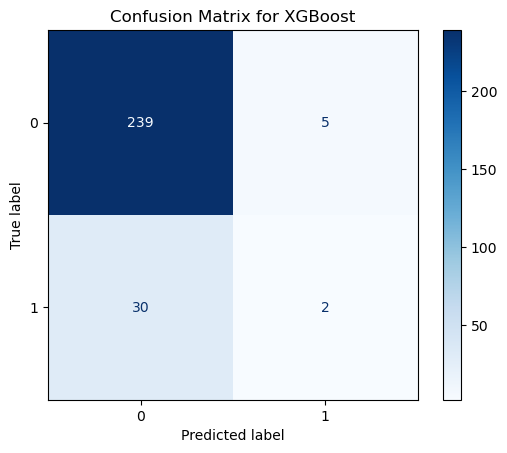



Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       244
           1       0.29      0.06      0.10        32

    accuracy                           0.87       276
   macro avg       0.59      0.52      0.52       276
weighted avg       0.82      0.87      0.84       276



In [81]:
y_pred_xgb = xgb.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb.classes_)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='.0f')
plt.title("Confusion Matrix for XGBoost")
plt.grid(False)
plt.show()
print("\n")

print("Classification Report for XGBoost:\n")

print(classification_report(y_test, y_pred_xgb))

# Tuning model's parameters

Grid search is a hyperparameter tuning technique used to find the best combination of model hyperparameters that yields the optimal performance for a machine learning model. It works by exhaustively searching through a manually specified subset of the hyperparameter space of a learning algorithm.

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
param_grid = {
   'learning_rate': [0.01, 0.05, 0.1],
   'max_depth': [3, 4, 5, 6],
   'n_estimators': [50, 100, 150, 200],
   'subsample': [0.8, 0.9, 1],
   'colsample_bytree': [0.8, 0.9, 1]



clf_xgb = XGBClassifier(random_state=10, use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(clf_xgb, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.9}


In [95]:
xgb_best = XGBClassifier(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=150,
    subsample=0.9,
    random_state=10,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_model = xgb_best.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("Classification Report for the Model")
print(classification_report(y_test, y_pred_best))

Classification Report for the Model
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       244
           1       0.25      0.03      0.06        32

    accuracy                           0.88       276
   macro avg       0.57      0.51      0.49       276
weighted avg       0.81      0.88      0.83       276



# Using the model

In [99]:
# Generating random customer to test the model

customer = {
"gender": "female",
 "car_owner": "Y",
 "propert_owner": "Y",
 "children": 0,
 "type_income": "Commercial associate",
 "education":"Higher education",
 "marital_status": "Married",
 "housing_type": "House / apartment",
 "birthday_count": -13557,
 "work_phone": 0,
 "phone": 1,
 "email_id": 1,
 "type_occupation": "Managers",
 "family_members": 2,
 "employed_days": -2418,
 "Annual_income": 95850
}

We will display the probability of negative class, which is credit card approval in our case

In [101]:
test = dv.transform([customer])
best_model.predict_proba(test)[0, 0] 
# using the notation [0, 0] to retrieve the probability of the negative class

0.9399257

# Saving and loading the model

In [102]:
import pickle

In [107]:
with open('project.bin', 'wb') as f_out:
    pickle.dump((dv, best_model), f_out)

In [108]:
with open('project.bin', 'rb') as f_in:
    dv, best_model = pickle.load(f_in)

In [109]:
dv, best_model

(DictVectorizer(sparse=False),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=150,
               n_jobs=None, num_parallel_tree=None, random_state=10, ...))

# Conclusion

Throughout this project, we successfully managed and processed the dataset, addressing missing data and outliers. Utilizing both logistic regression and tree-based models, we effectively handled categorical and numerical data through one-hot encoding. By mitigating the challenges of imbalanced data, tuning hyperparameters, and deploying the model, we were able to achieve a comprehensive and robust solution for the task at hand.